Using device: cpu
✅ YOLOv11 model 'best.pt' loaded successfully.


C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ Feature extractor (ResNet50) loaded and configured.

--- Testing YOLOv11 Detection ---
✅ Sample frame saved as 'sample_frame_from_broadcast.jpg'
Detected 3 players in sample frame (after confidence threshold).


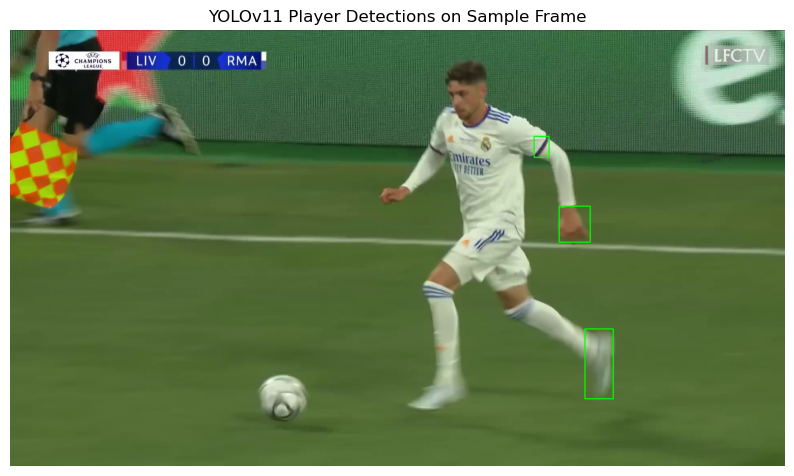


--- Extracting Features ---
Starting feature extraction for: C:\Users\DELL\Downloads\Soccer Player Cross-Camera Mapping\broadcast.mp4


Processing broadcast.mp4: 100%|██████████████████████████████████████████████████████| 132/132 [05:46<00:00,  2.63s/it]


Finished feature extraction for: C:\Users\DELL\Downloads\Soccer Player Cross-Camera Mapping\broadcast.mp4. Processed 132 frames.
📦 Broadcast features extracted: 1316 player detections across 132 frames.
Starting feature extraction for: C:\Users\DELL\Downloads\Soccer Player Cross-Camera Mapping\tacticam.mp4


Processing tacticam.mp4: 100%|███████████████████████████████████████████████████████| 201/201 [15:12<00:00,  4.54s/it]


Finished feature extraction for: C:\Users\DELL\Downloads\Soccer Player Cross-Camera Mapping\tacticam.mp4. Processed 201 frames.
📦 Tacticam features extracted: 4163 player detections across 201 frames.

--- Matching Players ---
Starting player matching...


Matching frames: 100%|███████████████████████████████████████████████████████████████| 201/201 [04:20<00:00,  1.30s/it]

Finished player matching. Found 2715 matches.
🔗 Matched players (unique matches found based on player_id logic): 2715

--- Saving Results ---
✅ Saved player_id_mapping.csv with 2715 entries.

--- Process Complete ---


In [1]:
import cv2
import torch
import numpy as np
from ultralytics import YOLO
from torchvision import models, transforms
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image # PIL is useful for image manipulation before passing to transforms
import pandas as pd
import os

# --- Configuration ---
YOLO_MODEL_PATH = "best.pt"  # Path to your YOLOv11 weights
BROADCAST_VIDEO_PATH = r"C:\Users\DELL\Downloads\Soccer Player Cross-Camera Mapping\broadcast.mp4"
TACTICAM_VIDEO_PATH = r"C:\Users\DELL\Downloads\Soccer Player Cross-Camera Mapping\tacticam.mp4"

CONFIDENCE_THRESHOLD = 0.5  # YOLO detection confidence threshold
SIMILARITY_THRESHOLD = 0.7  # Cosine similarity threshold for player matching

# Use GPU if available
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

# --- 1. Load YOLOv11 model ---
try:
    yolo_model = YOLO(YOLO_MODEL_PATH)
    print(f"✅ YOLOv11 model '{YOLO_MODEL_PATH}' loaded successfully.")
except Exception as e:
    print(f"❌ Error loading YOLOv11 model: {e}")
    print("Please ensure 'best.pt' is in the correct directory and is a valid YOLOv11 model file.")
    exit()

# --- 2. Load a pre-trained model for feature extraction (e.g., ResNet) ---
# We'll use a ResNet50 pretrained on ImageNet, remove the final classification layer.
feature_extractor = models.resnet50(pretrained=True)
feature_extractor = torch.nn.Sequential(*(list(feature_extractor.children())[:-1])) # Remove the last fully connected layer
feature_extractor.to(DEVICE)
feature_extractor.eval() # Set to evaluation mode

# Define transformations for the image crops before feeding to ResNet
preprocess = transforms.Compose([
    transforms.Resize((224, 224)), # ResNet expects 224x224 input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
print("✅ Feature extractor (ResNet50) loaded and configured.")

# --- Helper function to extract features from a single image crop ---
def get_features_from_crop(image_crop):
    if image_crop is None:
        return None
    # Convert numpy array (BGR) to PIL Image (RGB) for torchvision transforms
    image_crop_rgb = Image.fromarray(cv2.cvtColor(image_crop, cv2.COLOR_BGR2RGB))
    input_tensor = preprocess(image_crop_rgb)
    input_batch = input_tensor.unsqueeze(0) # Create a mini-batch as expected by the model

    with torch.no_grad():
        output = feature_extractor(input_batch.to(DEVICE))
    return output.flatten().cpu().numpy() # Flatten and move to CPU

# --- 3. Function to extract features from a video ---
def extract_features_from_video(video_path, model, confidence_threshold=0.5):
    """
    Extracts player detections and their features from a video.
    Returns a list of dictionaries, one per frame, containing player info.
    Each player info dict includes: {'box': [x1,y1,x2,y2], 'feature': numpy_array}
    """
    print(f"Starting feature extraction for: {video_path}")
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"❌ Error: Could not open video {video_path}")
        return []

    all_frame_data = []
    frame_id = 0

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    pbar = tqdm(total=total_frames, desc=f"Processing {os.path.basename(video_path)}")

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_players = []
        results = model(frame, verbose=False, conf=confidence_threshold) # Set confidence directly here

        if results and results[0].boxes:
            for box in results[0].boxes:
                # Assuming class 0 is 'player' based on typical YOLO training for 'person'
                # You might need to adjust `box.cls[0].item()` if your 'best.pt' has a different class ID for players.
                # It's safer to check `model.names` if available.
                class_id = int(box.cls[0].item())
                if model.names[class_id] == 'player': # Adjust this based on your model's actual class name for players
                    x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
                    conf = float(box.conf[0].item())

                    # Ensure coordinates are within frame boundaries
                    h, w, _ = frame.shape
                    x1 = max(0, x1)
                    y1 = max(0, y1)
                    x2 = min(w, x2)
                    y2 = min(h, y2)

                    player_crop = frame[y1:y2, x1:x2]
                    if player_crop.shape[0] > 0 and player_crop.shape[1] > 0: # Ensure crop is not empty
                        player_feature = get_features_from_crop(player_crop)
                        if player_feature is not None:
                            frame_players.append({
                                'box': [x1, y1, x2, y2],
                                'confidence': conf,
                                'feature': player_feature,
                                'original_frame_id': frame_id # Keep track of original frame
                            })
        all_frame_data.append({'frame_id': frame_id, 'players': frame_players})
        frame_id += 1
        pbar.update(1)

    cap.release()
    pbar.close()
    print(f"Finished feature extraction for: {video_path}. Processed {frame_id} frames.")
    return all_frame_data

# --- 4. Function to match players across videos ---
def match_players(tacticam_frames_data, broadcast_frames_data, similarity_threshold=0.7, max_frame_diff=5):
    """
    Matches players between tactican and broadcast videos based on feature similarity.
    This simplified version assumes approximate time synchronization and matches based on nearest frames.
    For robust tracking, a dedicated tracking algorithm (e.g., DeepSORT) would be used first
    within each video to get consistent IDs, then these track-level features would be matched.
    """
    print("Starting player matching...")
    matches = []
    # This logic matches players in tacticam frames to players in broadcast frames.
    # A more advanced approach would involve a full tracking solution and then
    # matching the tracks.

    # Let's create a global player ID assignment system
    global_player_id_counter = 0
    tacticam_player_to_global_id = {} # Maps (frame_id, player_idx_in_frame) -> global_id
    broadcast_player_to_global_id = {} # Maps (frame_id, player_idx_in_frame) -> global_id
    
    # Store global IDs for matched players (used for CSV output)
    final_matches_for_csv = []

    # Iterate through tacticam frames
    for tacticam_frame_data in tqdm(tacticam_frames_data, desc="Matching frames"):
        tacticam_frame_id = tacticam_frame_data['frame_id']
        tacticam_players = tacticam_frame_data['players']

        if not tacticam_players:
            continue

        # Look for broadcast frames in a small temporal window around the current tacticam frame
        # This accounts for slight desync or frame rate differences
        candidate_broadcast_frames = []
        for i in range(max(0, tacticam_frame_id - max_frame_diff), min(len(broadcast_frames_data), tacticam_frame_id + max_frame_diff + 1)):
            candidate_broadcast_frames.append(broadcast_frames_data[i])
        
        if not candidate_broadcast_frames:
            continue

        # For each player in the current tacticam frame
        for i, tp in enumerate(tacticam_players):
            best_match = None
            max_similarity = -1

            # Compare with players in candidate broadcast frames
            for broadcast_frame_data in candidate_broadcast_frames:
                broadcast_frame_id = broadcast_frame_data['frame_id']
                broadcast_players = broadcast_frame_data['players']

                if not broadcast_players:
                    continue

                for j, bp in enumerate(broadcast_players):
                    similarity = cosine_similarity(tp['feature'].reshape(1, -1), bp['feature'].reshape(1, -1))[0][0]

                    if similarity > max_similarity and similarity >= similarity_threshold:
                        max_similarity = similarity
                        best_match = {
                            'tacticam_frame': tacticam_frame_id,
                            'tacticam_player_index': i,
                            'broadcast_frame': broadcast_frame_id,
                            'broadcast_player_index': j,
                            'score': similarity
                        }
            
            if best_match:
                # Assign/retrieve global player ID
                tacticam_key = (best_match['tacticam_frame'], best_match['tacticam_player_index'])
                broadcast_key = (best_match['broadcast_frame'], best_match['broadcast_player_index'])

                if tacticam_key in tacticam_player_to_global_id:
                    global_id = tacticam_player_to_global_id[tacticam_key]
                elif broadcast_key in broadcast_player_to_global_id:
                    global_id = broadcast_player_to_global_id[broadcast_key]
                else:
                    global_player_id_counter += 1
                    global_id = global_player_id_counter
                
                tacticam_player_to_global_id[tacticam_key] = global_id
                broadcast_player_to_global_id[broadcast_key] = global_id
                
                best_match['player_id'] = global_id
                final_matches_for_csv.append(best_match)

    print(f"Finished player matching. Found {len(final_matches_for_csv)} matches.")
    return final_matches_for_csv

# --- Main Execution Flow ---

# 1. Test YOLO detection on a sample frame
print("\n--- Testing YOLOv11 Detection ---")
# Ensure the video path is correct and accessible
if not os.path.exists(BROADCAST_VIDEO_PATH):
    print(f"❌ Broadcast video not found at: {BROADCAST_VIDEO_PATH}")
    # You might want to exit or provide a mock frame here
    exit()

cap_test = cv2.VideoCapture(BROADCAST_VIDEO_PATH)
ret_test, frame_test = cap_test.read()
cap_test.release()

if ret_test:
    cv2.imwrite("sample_frame_from_broadcast.jpg", frame_test)
    print("✅ Sample frame saved as 'sample_frame_from_broadcast.jpg'")

    # Load the saved image for display
    frame_display = cv2.imread("sample_frame_from_broadcast.jpg")
    results_display = yolo_model(frame_display, verbose=False, conf=CONFIDENCE_THRESHOLD)

    # Draw bounding boxes
    boxes_display = results_display[0].boxes.xyxy.cpu().numpy() if results_display[0].boxes else []
    detected_players_count = 0
    if results_display[0].boxes:
        for box in results_display[0].boxes:
             class_id = int(box.cls[0].item())
             if yolo_model.names[class_id] == 'player': # Check if it's a player
                x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
                cv2.rectangle(frame_display, (x1, y1), (x2, y2), (0, 255, 0), 2)
                detected_players_count += 1

    print(f"Detected {detected_players_count} players in sample frame (after confidence threshold).")

    # Show the frame with boxes
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(frame_display, cv2.COLOR_BGR2RGB))
    plt.title("YOLOv11 Player Detections on Sample Frame")
    plt.axis("off")
    plt.show()
else:
    print("❌ Could not read frame from broadcast.mp4 for sample detection.")


# 2. Extract features from both videos
print("\n--- Extracting Features ---")
broadcast_feats = extract_features_from_video(BROADCAST_VIDEO_PATH, yolo_model, CONFIDENCE_THRESHOLD)
print(f"📦 Broadcast features extracted: {sum(len(f['players']) for f in broadcast_feats)} player detections across {len(broadcast_feats)} frames.")

tacticam_feats = extract_features_from_video(TACTICAM_VIDEO_PATH, yolo_model, CONFIDENCE_THRESHOLD)
print(f"📦 Tacticam features extracted: {sum(len(f['players']) for f in tacticam_feats)} player detections across {len(tacticam_feats)} frames.")

# 3. Match players
print("\n--- Matching Players ---")
matches = match_players(tacticam_feats, broadcast_feats, SIMILARITY_THRESHOLD)
print("🔗 Matched players (unique matches found based on player_id logic):", len(matches))

# 4. Save to CSV
print("\n--- Saving Results ---")
if matches:
    df = pd.DataFrame([{
        "tacticam_frame": m["tacticam_frame"],
        "broadcast_frame": m["broadcast_frame"],
        "player_id": m["player_id"],
        "similarity_score": m["score"]
    } for m in matches])

    df.to_csv("player_id_mapping.csv", index=False)
    print("✅ Saved player_id_mapping.csv with", len(df), "entries.")
else:
    print("⚠️ No matches found to save to CSV.")

print("\n--- Process Complete ---")